# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 1st, 2022 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/ (we won't be doing peergrading, but we'll still use http://peergrade.io/ for the handin.)

In [ ]:
!pip install wikipedia
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ast import literal_eval
import pandas as pd 
import numpy as np
import nltk
import re
from nltk import word_tokenize
import wikipedia
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import networkx as nx
import collections
import powerlaw
import random
from fa2 import ForceAtlas2


# Data

This assignment will be based on the DC and Marvel superhero dataset you downloaded during the Week 4 exercises. It's important that you work with your own dataset.

You will need the network structure and the page texts to complete the assignment.

To show that you have collected these files, please place your files somewhere that's accessible online (e.g. a github repo or a webpage) and link to your files from your notebook. (We will appreciate it if you store the wiki pages in plain text and the network as an edgelist. )

In [ ]:
# reading data and creating dataframes for each universe
dc_big_df = pd.read_csv('dc_cleaned.csv', index_col=0)
marvel_big_df = pd.read_csv('marvel_cleaned.csv', index_col=0)
dc_big_df['links'] = dc_big_df['links'].apply(lambda x: literal_eval(x))
marvel_big_df['links'] = marvel_big_df['links'].apply(lambda x: literal_eval(x))

In [ ]:
# counting words for each text
marvel_big_df['n_words_desc'] = marvel_big_df.text.apply(lambda text:len([word for word in re.sub('\W+',' ', text).split(' ') if len(word) > 1]) )
dc_big_df['n_words_desc'] = dc_big_df.text.apply(lambda text:len([word for word in re.sub('\W+',' ', text).split(' ') if len(word) > 1]) )

#GEtting edges by exploding list of links in each dataframe
all_heroes = np.concatenate((dc_big_df.hero.values,marvel_big_df.hero.values))
dc_big_df['heroes_links'] = dc_big_df['links'].apply(lambda x: list(set(x).intersection(all_heroes)))
dc_big_df['universe'] = 'dc'
marvel_big_df['heroes_links'] = marvel_big_df['links'].apply(lambda x: list(set(x).intersection(all_heroes)))
marvel_big_df['universe'] = 'marvel'
dc_links_df= dc_big_df[['hero','heroes_links','universe']]
dc_explode=dc_links_df.explode('heroes_links').reset_index(drop=True)
marvel_links_df= marvel_big_df[['hero','heroes_links','universe']]
marvel_explode=marvel_links_df.explode('heroes_links').reset_index(drop=True)

dc_edges = list(dc_explode[['hero','heroes_links']].itertuples(index=False, name=None))
marvel_edges = list(marvel_explode[['hero','heroes_links']].itertuples(index=False, name=None))

#creating graph
G = nx.DiGraph()
dc_words = dc_big_df['n_words_desc'].values
for i, hero in enumerate(dc_big_df['hero'].values):
    G.add_node(hero, universe='dc', n_words_desc=dc_words[i])
    
marvel_words = marvel_big_df['n_words_desc'].values
for i, hero in enumerate(marvel_big_df['hero'].values):
    G.add_node(hero, universe='marvel', n_words_desc=marvel_words[i])
    
G.add_edges_from(dc_edges)
G.add_edges_from(marvel_edges)

dc_links_df['n_edges'] = dc_links_df['heroes_links'].apply(lambda x: len(x))
marvel_links_df['n_edges'] = marvel_links_df['heroes_links'].apply(lambda x: len(x))

marvel_no_links = marvel_links_df[marvel_links_df['n_edges']==0]['hero'].values
dc_no_links = dc_links_df[dc_links_df['n_edges']==0]['hero'].values

#removing nodes with no edges
G.remove_nodes_from(marvel_no_links)
G.remove_nodes_from(dc_no_links)

C:\Users\felip\AppData\Local\Temp\ipykernel_3764\432678594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_links_df['n_edges'] = dc_links_df['heroes_links'].apply(lambda x: len(x))
C:\Users\felip\AppData\Local\Temp\ipykernel_3764\432678594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marvel_links_df['n_edges'] = marvel_links_df['heroes_links'].apply(lambda x: len(x))


In [ ]:
nx.write_gpickle(G,'marvel_dc_graph.pkl')

In [ ]:
marvel_nodes = list(
    node
    for node, data
    in G.nodes(data=True)
    if data.get("universe") == "marvel"
)

dc_nodes = list(
    node
    for node, data
    in G.nodes(data=True)
    if data.get("universe") == "dc"
)
partition_dict = {}
for i in marvel_nodes:
    partition_dict[i]='dc'
for i in dc_nodes:
    partition_dict[i]='marvel' 

In [ ]:
Non_dir_G = nx.Graph(G)

In [ ]:
marvel_G = Non_dir_G.subgraph(marvel_nodes)
dc_G = Non_dir_G.subgraph(dc_nodes)

In [ ]:
marvel_L = len(list(marvel_G.edges))
dc_L = len(list(dc_G.edges))
marvel_k = len(list(marvel_G.nodes))
dc_k = len(list(dc_G.nodes))
total_L = len(list(Non_dir_G.edges))


In [ ]:
marvel_part = marvel_L/total_L - (marvel_k/(2*(total_L)))**2
dc_part = dc_L/total_L - (dc_k/(2*(total_L)))**2
total = marvel_part + dc_part
print(total)

0.9850198128737111


# Basic Stats

Write a short paragraph describing the network. The paragraph should contain the following information

* The number of nodes and links. 
* The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

We also want the degree distributions and a plot of the network

* Create and visualize in- and out-going degree distributions as described in Lecture 4. Think about which axes you should use - loglog is great for power-law distributions, but not necessarily for Poisson-like degree distributions.
* Estimate, report, and reflect on the slope and starting value of the incoming degree distribtion's power law using the tools described in Lecture 5 - and display the fit on top of your incoming degree-distribution plot.
* Plot the network using the Force Atlas algorithm as described in Lecture 5.

(Friendly hint: Remember figure captions.)

In [ ]:
import statistics as st
in_degrees = [x[1] for x in list(G.in_degree())]
n_nodes = len(G.nodes())
n_edges = len(G.edges())
print('n nodes: ', len(G.nodes()))
print('n edges: ', len(G.edges()))

in_mean = round(np.mean(in_degrees),2)
in_mode = st.mode(in_degrees)
in_median = np.percentile(in_degrees, 50)
in_max = np.max(in_degrees)
in_min = np.min(in_degrees)



out_degrees = [x[1] for x in list(G.out_degree())]
out_mean = round(np.mean(out_degrees),2)
out_mode = st.mode(out_degrees)
out_median = np.percentile(out_degrees, 50)
out_max = np.max(out_degrees)
out_min = np.min(out_degrees)


n nodes:  1482
n edges:  18212


> * The network has a total of 1482 nodes and 18212 edges. The everage degree is the same for in and out, as expected and the other statistics are displayed in the dataframe in the cell bellow:

In [ ]:

statistics = ['mean', 'mode', 'median', 'max', 'min']
in_stats = [in_mean, in_mode, in_median, in_max, in_min]
out_stats = [out_mean, out_mode, out_median, out_max, out_min]
pd.DataFrame({'statistic':statistics, 'in-degree':in_stats, 'out-degree':out_stats}).set_index('statistic').T

statistic,mean,mode,median,max,min
in-degree,12.29,0.0,5.0,377.0,0.0
out-degree,12.29,6.0,9.0,73.0,0.0


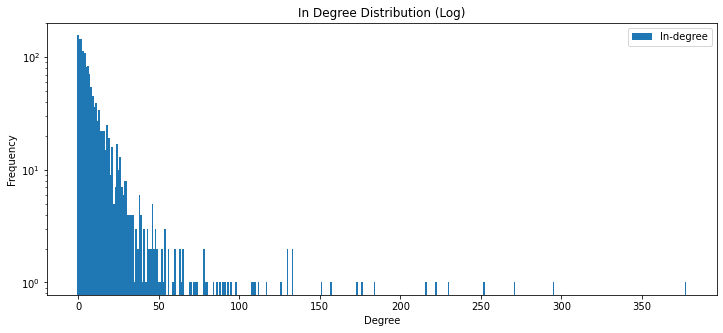

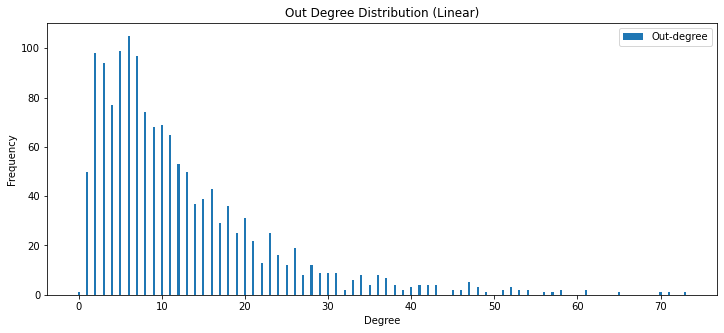

In [ ]:
# Plotting the in-degree distribution
in_degree = sorted([d for n, d in G.in_degree()])
in_degree_count = collections.Counter(in_degree)
in_deg, in_count = zip(*in_degree_count.items())

plt.figure(figsize=(12,5))
plt.bar(in_deg, in_count, width=1, log=True)
plt.title("In Degree Distribution (Log)")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend(['In-degree'])
plt.show()







# Plotting the out-degree distribution
out_degree = sorted([d for n, d in G.out_degree()])
out_degree_count = collections.Counter(out_degree)
out_deg, out_count = zip(*out_degree_count.items())

plt.figure(figsize=(12,5))
plt.bar(out_deg, out_count, width=0.25, log=False)
plt.title("Out Degree Distribution (Linear)")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend(['Out-degree'])
plt.show()

In [ ]:
in_power = powerlaw.Fit(in_degree)
print('estimated power law exponent for in-degree distribution: ',in_power.power_law.alpha)

estimated power law exponent for in-degree distribution:  2.5718869550844743


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\felip\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


In [ ]:
out_power = powerlaw.Fit(out_degree)
print('estimated power law exponent for out-degree distribution: ',out_power.power_law.alpha)

estimated power law exponent for out-degree distribution:  3.7501067198283913


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


$$
    \text{Regime}= 
\begin{cases}
    \text{Anomolous},& \text{if } \gamma \leq 2 \\
    \text{Scale-free},& \text{if } 2<\gamma <3\\
    \text{Random Network},& \text{if } 3 < \gamma\\
\end{cases}
$$

>* We can see that the out degree distribution with a $\gamma > 3$ puts the network in the Random network regime. That means the behavior of the scale free network doenst differ from the behavior of a random network. This reflects in the degree distribution plot, where there doesnt seem to be the need to log scale the axis, as it doent seem to be exponentially distributed. The out-degree from a specific hero Wiki page might be interpreted as metric for the complexity of their background story, aka lore. The more heroes mentioned in his/her wiki, the more complex it story. Therefore, it is reasonable to assume that the distribution of complexity scores is not really exponentially distributed (or pareto distributed).  
> * The in degree distribution demonstrates more of a exponential distribution. The estimated exponent is in the interval $2 < \gamma < 3$, which determines a Scale-free regime. This exponential behavior makes sense as the in-degree distribution represents how many other heroes mention the hero at hand. This could be interpreted as a sort of popularity score, or the importance of that one hero in the comic universe. As it is to be expected, a small group of heroes (e.g. Batman, Spide-Man, Super Man) concentrate the most citations. 

In [ ]:
# getting number of edges from the network
N = len(G.nodes())

In [ ]:
# simulating in degree power law distributed sequence and configuration model (BA graph) with estimated gamma
in_sequence = nx.utils.powerlaw_sequence(N,exponent= in_power.power_law.alpha)
in_sequence = [int(x) for x in in_sequence]
if sum(in_sequence)%2!=0:
    node_idx=random.choice(range(0,len(in_sequence)))
    in_sequence[node_idx]+=1
simulated_BA_in = nx.configuration_model(in_sequence)

In [ ]:
# getting the distribution
BA_in_degree = sorted([d for n, d in simulated_BA_in.degree()])
BA_in_degree_count = collections.Counter(BA_in_degree)
BA_in_deg, BA_in_count = list(dict(BA_in_degree_count).keys()), list(dict(BA_in_degree_count).values())

In [ ]:
# simulating out degree power law distributed sequence and configuration model (BA graph) with estimated gamma
out_sequence = nx.utils.powerlaw_sequence(N,exponent= out_power.power_law.alpha)
out_sequence = [int(x) for x in out_sequence]
if sum(out_sequence)%2!=0:
    node_idx=random.choice(range(0,len(out_sequence)))
    out_sequence[node_idx]+=1
simulated_BA_out = nx.configuration_model(out_sequence)

In [ ]:
# getting the distribution
BA_out_degree = sorted([d for n, d in simulated_BA_out.degree()])
BA_out_degree_count = collections.Counter(BA_out_degree)
BA_out_deg, BA_out_count = list(dict(BA_out_degree_count).keys()), list(dict(BA_out_degree_count).values())

C:\Users\felip\AppData\Local\Temp\ipykernel_3764\70758469.py:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(in_deg), np.log(in_count), color='hotpink')


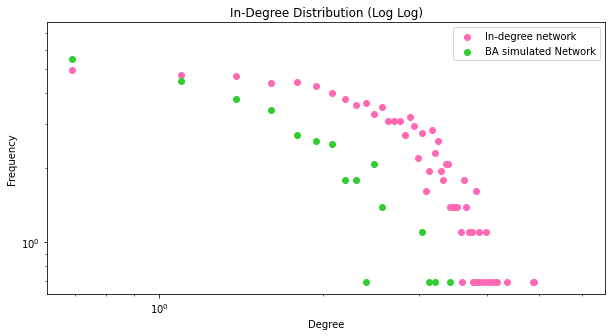

In [ ]:
# Plot the in-degree distribution compared to simulated version with same gamma
fig, ax = plt.subplots(figsize = (10,5))
plt.scatter(np.log(in_deg), np.log(in_count), color='hotpink')
plt.scatter(np.log(BA_in_deg), np.log(BA_in_count), color='limegreen')
plt.xscale('log')
plt.yscale('log')
plt.title('In-Degree Distribution (Log Log)')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.legend(['In-degree network','BA simulated Network'])
plt.show()

C:\Users\felip\AppData\Local\Temp\ipykernel_3764\3044214462.py:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(out_deg), np.log(out_count), color='blue')


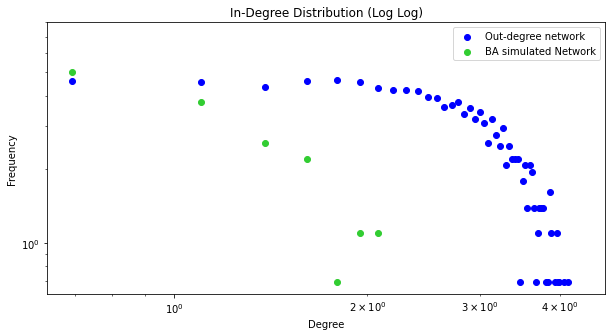

In [ ]:
# Plot the out-degree distribution compared to simulated version with same gamma
fig, ax = plt.subplots(figsize = (10,5))
plt.scatter(np.log(out_deg), np.log(out_count), color='blue')
plt.scatter(np.log(BA_out_deg), np.log(BA_out_count), color='limegreen')
plt.xscale('log')
plt.yscale('log')
plt.title('In-Degree Distribution (Log Log)')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.legend(['Out-degree network','BA simulated Network'])
plt.show()

>* it is easy to see that the in degree network and BA simulated network with same $\gamma$ show a reasonably good fit, as both curves are close together. On the other hand, when it comes to the out degree distribution, the fit seems much poorer, as the simulated BA network differs quite a lot from the out-degree graph curve. 

In [ ]:
# getting undirected version of the Graph
Non_dir_G = nx.Graph(G)

In [ ]:
node_colors=[]
dc_heroes, marvel_heroes = set(dc_big_df.hero.values), set(marvel_big_df.hero.values)
for node in Non_dir_G.nodes(data=True):
    if node[0] in marvel_heroes:
        node_colors.append('#000000')
    else:
        node_colors.append('#880808')

pos = nx.kamada_kawai_layout(Non_dir_G)
degrees = [val for node,val in Non_dir_G.degree()]

100%|██████████| 400/400 [00:04<00:00, 83.26it/s]


BarnesHut Approximation  took  2.31  seconds
Repulsion forces  took  2.06  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


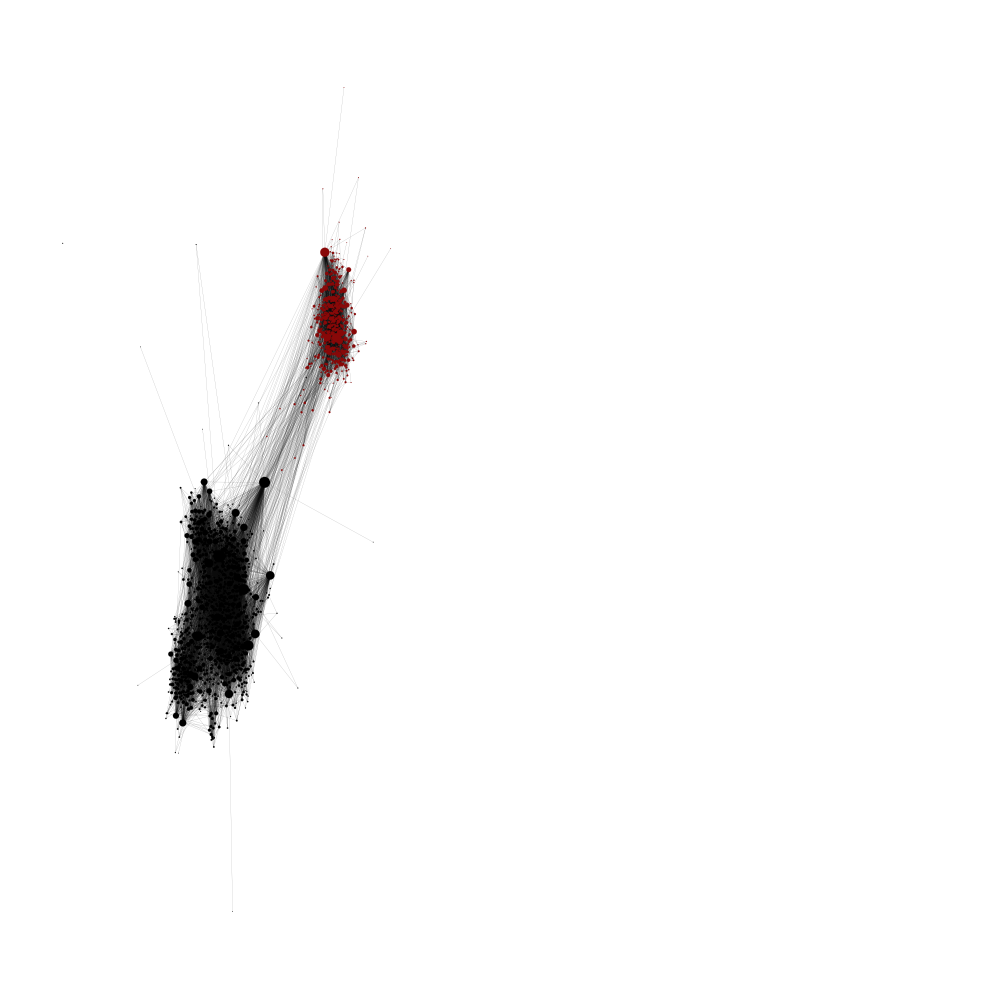

In [ ]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
Non_dir_G = nx.Graph(G)
fig = plt.figure(1, figsize=(100, 100), dpi=10,tight_layout=True)
forceatlas2 = ForceAtlas2(
                        outboundAttractionDistribution=True, 
                        linLogMode=False,
                        adjustSizes=False,  
                        edgeWeightInfluence=1.0,
                        barnesHutOptimize=True,
                        barnesHutTheta=2,
                        multiThreaded=False, 
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1,
                        verbose=True)
node_size = [i * 20 for i in degrees]
positions = forceatlas2.forceatlas2_networkx_layout(Non_dir_G, pos=pos, iterations=400)
nx.draw_networkx_nodes(Non_dir_G, positions, node_size=node_size, node_color=node_colors, alpha=1)
nx.draw_networkx_edges(Non_dir_G, positions, alpha=0.5)
plt.axis('off')
plt.show()

# Communities

Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

In [ ]:
dc_big_df.head()

,Unnamed: 0,hero,text,links,heroes_links,universe,text_cleaned,n_words_desc
0,0,Abin Sur,{{Refimprove|date=March 2008}}\n{{Infobox comi...,"[DC Comics, John Broome (writer), Gil Kane, Li...","[Green Lantern, Bulletman and Bulletgirl, Lex ...",dc,Abin Sur is a superhero appearing in American ...,4890
1,1,Abra Kadabra (character),{{Infobox comics character\n<!--Wikipedia:Wiki...,"[Oscar Jimenez (comics), Anibal Rodriguez, Hum...","[Captain Cold, Heat Wave (comics), Weather Wiz...",dc,Abra Kadabra Citizen Abra is a magical supervi...,2420
2,2,Abby Holland,{{short description|Fictional comic book chara...,"[File:SwampThing22.jpg, Swamp Thing (comic boo...","[Anton Arcane, Etrigan the Demon, Batman, Dead...",dc,Abigail Arcane Cable Holland is a fictional co...,4104
3,3,Ace the Bat-Hound,{{short description|DC Comics character}}\n{{U...,"[Detective Comics, 2019 in comics, Tony S. Dan...","[Raven (DC Comics), Azrael (DC Comics), Animal...",dc,Ace the Bat Hound is a superhero dog appearing...,2937
4,4,Adam Strange,{{Short description|DC Comics fictional charac...,"[Alex Ross, DC Comics, Showcase (comics), Juli...","[Green Lantern, Hawkman, Animal Man, Batman, D...",dc,New 52 Omniscience Omnipresence Omnipotence,6762


In [ ]:
marvel_big_df['n_words_desc'] = marvel_big_df.text.apply(lambda text:len([word for word in re.sub('\W+',' ', text).split(' ') if len(word) > 1]) )
dc_big_df['n_words_desc'] = dc_big_df.text.apply(lambda text:len([word for word in re.sub('\W+',' ', text).split(' ') if len(word) > 1]) )



all_heroes = np.concatenate((dc_big_df.hero.values,marvel_big_df.hero.values))
dc_big_df['heroes_links'] = dc_big_df['links'].apply(lambda x: list(set(x).intersection(all_heroes)))
dc_big_df['universe'] = 'dc'
marvel_big_df['heroes_links'] = marvel_big_df['links'].apply(lambda x: list(set(x).intersection(all_heroes)))
marvel_big_df['universe'] = 'marvel'
dc_links_df= dc_big_df[['hero','heroes_links','universe']]
dc_explode=dc_links_df.explode('heroes_links').reset_index(drop=True)
marvel_links_df= marvel_big_df[['hero','heroes_links','universe']]
marvel_explode=marvel_links_df.explode('heroes_links').reset_index(drop=True)


dc_edges = list(dc_explode[['hero','heroes_links']].itertuples(index=False, name=None))
marvel_edges = list(marvel_explode[['hero','heroes_links']].itertuples(index=False, name=None))

import networkx as nx
G = nx.DiGraph()
dc_words = dc_big_df['n_words_desc'].values
for i, hero in enumerate(dc_big_df['hero'].values):
    G.add_node(hero, universe='dc', n_words_desc=dc_words[i])
    
marvel_words = marvel_big_df['n_words_desc'].values
for i, hero in enumerate(marvel_big_df['hero'].values):
    G.add_node(hero, universe='marvel', n_words_desc=marvel_words[i])
    
G.add_edges_from(dc_edges)
G.add_edges_from(marvel_edges)

dc_links_df['n_edges'] = dc_links_df['heroes_links'].apply(lambda x: len(x))
marvel_links_df['n_edges'] = marvel_links_df['heroes_links'].apply(lambda x: len(x))

marvel_no_links = marvel_links_df[marvel_links_df['n_edges']==0]['hero'].values
dc_no_links = dc_links_df[dc_links_df['n_edges']==0]['hero'].values

G.remove_nodes_from(marvel_no_links)
G.remove_nodes_from(dc_no_links)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
Non_dir_G = nx.Graph(G)

In [ ]:
marvel_nodes = list(
    node
    for node, data
    in Non_dir_G.nodes(data=True)
    if data.get("universe") == "marvel"
)

dc_nodes = list(
    node
    for node, data
    in Non_dir_G.nodes(data=True)
    if data.get("universe") == "dc"
)
partition_dict = {}
for i in marvel_nodes:
    partition_dict[i]='dc'
for i in dc_nodes:
    partition_dict[i]='marvel'  

In [ ]:
marvel_G = Non_dir_G.subgraph(marvel_nodes)
dc_G = Non_dir_G.subgraph(dc_nodes)

In [ ]:
marvel_L = len(list(marvel_G.edges))
dc_L = len(list(dc_G.edges))
marvel_k = len(list(marvel_G.nodes))
dc_k = len(list(dc_G.nodes))
total_L = len(list(Non_dir_G.edges))


In [ ]:
marvel_part = marvel_L/total_L - (marvel_k/(2*(total_L)))**2
dc_part = dc_L/total_L - (dc_k/(2*(total_L)))**2
total = marvel_part + dc_part
print(total)

0.9850198128737111


In [ ]:
!pip install community

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


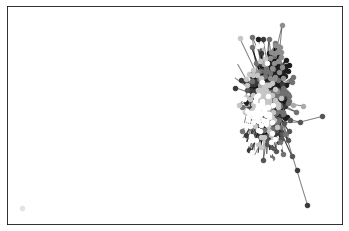

In [ ]:
from community import community_louvain
#first compute the best partition
partition = community_louvain.best_partition(dc_G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(dc_G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(dc_G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(dc_G,pos, alpha=0.5)
plt.show()

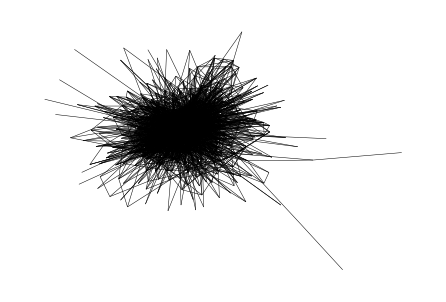

In [ ]:

import copy
import networkx
import matplotlib.pyplot as plt

# Generate a graph.
# Here I chose an ER graph.

# Get positions.
# Here I use the spectral layout and add a little bit of noise.

# Create position copies for shadows, and shift shadows
pos_shadow = copy.deepcopy(pos)
shift_amount = 0.006
for idx in pos_shadow:
    pos_shadow[idx][0] += shift_amount
    pos_shadow[idx][1] -= shift_amount

#~~~~~~~~~~~~
# Draw graph
#~~~~~~~~~~~~
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

nx.draw_networkx_edges(dc_G, pos, width=0.5)

In [ ]:
marvel_partition = community_louvain.best_partition(marvel_G)

In [ ]:
count_dict = {}
count=0
for key, value in marvel_partition.items():
    count_dict[value]=0
for key, value in marvel_partition.items():
    count_dict[value]+=1  
    count = count+1

We used the Louvain algorithm to find the communities. It is an unsupervised algorithm that is able to detect communities without imputing their number nor sizes. It does so by finding the configuration of communities that maximize the modularity M. The method will randomly order all nodes in the network and it will remove and insert each node in a different community 𝐶 until no significant increase in modularity is verified, the significant value of modularity is given as input.

$M_c=\frac{1}{2L}\sum_{(i,j)}∈C_c(A_{ij}−p_{ij})$

After optimizing the modularity, all nodes belonging to the same community are merged into a single giant node. Links connecting the giant nodes are the result of the sum of the link values from the previous link connection.

We chose this algorithm because a higher modularity implies better partitioning and this algorithm focus on maximizing the modularity.

Reference: https://towardsdatascience.com/louvain-algorithm-93fde589f58c

For our graph we got a modularity of

In [ ]:
print(total)

0.9850198128737111


We have 9 communities distributed as follow

In [ ]:
count_dict

{0: 188, 1: 235, 2: 140, 3: 264, 4: 77, 6: 63, 7: 87, 8: 19, 5: 2}

The TF-IDF is a statistic that reflect how important is a word in a document. The process is as follow, taking a document corpus, we can can determine the importance of a word by taking a ratio of the frequency of how many time the word is in a document by the requency of that same word in the whole corpus. It's called term-frequency and inverse document frequency.

In [ ]:
res = list(partition.keys())
for key in res:
    community = partition.get(key)
    dc_big_df[dc_big_df['hero'] == key]
    dc_big_df[dc_big_df['hero'] == key]['community'] =community
dc_big_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Unnamed: 0,hero,text,links,heroes_links,universe,text_cleaned,n_words_desc
0,0,Abin Sur,{{Refimprove|date=March 2008}}\n{{Infobox comi...,"[DC Comics, John Broome (writer), Gil Kane, Li...","[Green Lantern, Bulletman and Bulletgirl, Lex ...",dc,Abin Sur is a superhero appearing in American ...,4890
1,1,Abra Kadabra (character),{{Infobox comics character\n<!--Wikipedia:Wiki...,"[Oscar Jimenez (comics), Anibal Rodriguez, Hum...","[Captain Cold, Heat Wave (comics), Weather Wiz...",dc,Abra Kadabra Citizen Abra is a magical supervi...,2420
2,2,Abby Holland,{{short description|Fictional comic book chara...,"[File:SwampThing22.jpg, Swamp Thing (comic boo...","[Anton Arcane, Etrigan the Demon, Batman, Dead...",dc,Abigail Arcane Cable Holland is a fictional co...,4104
3,3,Ace the Bat-Hound,{{short description|DC Comics character}}\n{{U...,"[Detective Comics, 2019 in comics, Tony S. Dan...","[Raven (DC Comics), Azrael (DC Comics), Animal...",dc,Ace the Bat Hound is a superhero dog appearing...,2937
4,4,Adam Strange,{{Short description|DC Comics fictional charac...,"[Alex Ross, DC Comics, Showcase (comics), Juli...","[Green Lantern, Hawkman, Animal Man, Batman, D...",dc,New 52 Omniscience Omnipresence Omnipotence,6762
...,...,...,...,...,...,...,...,...
413,491,Sparta of Synriannaq#Character history,{{Infobox comics character| <!--This box is pa...,"[Image:NT54.jpg, Donna Troy, Wonder Girl, Geor...",[Wonder Woman],dc,Sparta of Synriannaq is a fictional character ...,991
414,492,Cadre (comics)#Cadre of the Immortal,{{Short description|DC Comics supervillain gro...,"[DC Comics, Justice League of America, Gerry C...","[Livewire (DC Comics), Batman, Booster Gold, S...",dc,The Cadre is a DC Comics supervillain group ex...,1194
415,493,Hell (DC Comics)#Fiends,{{in-universe|date=November 2010}}\n{{Infobox ...,"[:Category:Comics publishing companies, DC Com...","[Nightmaster, Felix Faust, Enchantress (DC Com...",dc,Hell a k a Gehenna Hades Hel Jahannam Sheol an...,9605
416,494,Xombi,{{short description|Fictional comics character...,"[DC Comics, John Rozum, Denys Cowan, superhero...","[Green Lantern, Crispus Allen]",dc,Xombi is a superhero published by DC Comics He...,1348


# Sentiment

**First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.**

## Pre-processing & Functions 



In [ ]:
#Load LabMt happiness wordlist
labmt = pd.read_csv('./LabMT.tsv', sep="\t")

# Lookup dictionary of the LabMt Happiines wordlist
# (word : happiness_average)
labmt_lookup = pd.Series(labmt.happiness_average.values,index=labmt.word.values).to_dict()

In [ ]:
# Join both universe's data frames
frames = [dc_big_df, marvel_big_df]

df_marvel_dc = pd.concat(frames)

In [ ]:
# Store all the page's text in a dictionary to facilate the usage.
v = list(G.nodes()) # list of all characters

corpus_sentiment = {}

for idx,x in enumerate(v):
  text_character = df_marvel_dc['text_cleaned'].iloc[idx]
  corpus_sentiment[x] = text_character

In [ ]:
# Define cleaning text function to be used in the sentiment analysis
def cleaning_text_corpus(corpus_str):
    
    # Tokenizaion 
    tokens_list = nltk.word_tokenize(corpus_str)
    
    # Filter out non-alphabetic words
    words_list = [w.lower() for w in tokens_list if w.isalpha()]
    
    # Remove stopwords
    stopwords_set = set(stopwords.words('english'))
    no_sw_words_list = [w for w in words_list if w not in stopwords_set]
    
    # Stemming
    def stem(word):
        regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
        stem, suffix = re.findall(regexp, word)[0]
        return stem
    stemmed_words_list = [stem(w) for w in no_sw_words_list]
    
    # Lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    clean_words_list = [lemmatizer.lemmatize(w) for w in stemmed_words_list]
    
    return no_sw_words_list

In [ ]:
# Define a function that calculate sentiment given a list of tokens
def sentiment(tokens):
    
    ## happiness score
    hw = {k:v for k,v in labmt_lookup.items() if k in tokens}
    HW = dict(sorted(hw.items()))
    
    ## create frequency distribution of the token 
    text = nltk.Text(tokens)
    text_freq = nltk.FreqDist(text)
    
    ## normalize term frequency 
    sum_f = sum(text_freq.values())
    pi = {k:v/sum_f for k,v in text_freq.items()}
    
    ## sort pi by key values 
    PI = dict(sorted(pi.items()))
    
    ## calculate sentiment and round to 1 decimal
    sen = round(sum(HW[k]*PI[k] for k in HW),1)
    
    return sen 

*both functions above were loosely based on other documents*

## Sentiment Analysis 

In [ ]:
# Get the tokens for each page and store in a dictionary
# {page : list of tokens}
tokens = {}
for k,v in corpus_sentiment.items():
    print
    tokens[k] = list(set([w.lower() for w in cleaning_text_corpus(corpus_sentiment[k]) if w.isalpha()]))
print('Number of pages: ', len(tokens.keys()))

Number of pages:  1482


**Sentiment score for each page**

In [ ]:
# Sentiments Dictionary for every page
# {page : Sentiment Score}
sentiment_score = {}

for k,v in tokens.items():
    sentiment_score[k] = sentiment(tokens[k])

In [ ]:
# Get sentiments and Count in order to plot
sentiments = sorted([v for k,v in sentiment_score.items()],reverse = True)
sentimentscount = collections.Counter(sentiments)
sent, count = zip(*sentimentscount.items())

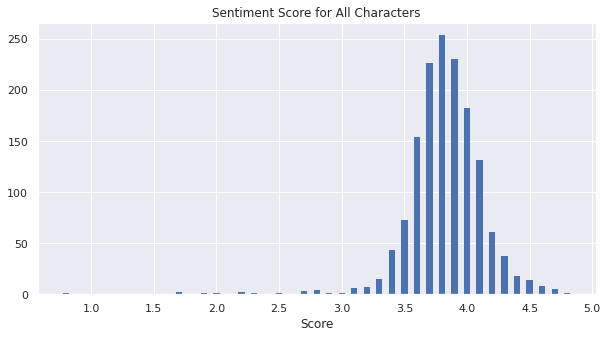

In [ ]:
# Plot Graph
with sns.axes_style("darkgrid"):
    plt.figure(figsize = [10, 5])
    plt.bar(sent, count, width=0.05, edgecolor = 'black',linewidth=0.01)
    plt.xlabel('Score')
    plt.title('Sentiment Score for All Characters')
    plt.show()

**All Characters Stats**

In [ ]:
print("Mean: " + str(sum(sentiment_score.values()) / len(sentiment_score.values())))
print("1Oth Percentile: " + str(np.percentile(list(sentiment_score.values()),10)))
print("90th Percentile: " + str(np.percentile(list(sentiment_score.values()),90)))

Mean: 3.8268556005398033
1Oth Percentile: 3.5
90th Percentile: 4.1


## Good and Bad Characters Analysis


Now grab the good/bad character names (from this file, see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

Finally use the label permutation test (see Week 5) to investigate the two hypotheses below

H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.

H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.
Write a short paragraph reflecting on your findings.

In [ ]:
# Load good and bad character CSV
good_and_bad_df = pd.read_csv('/content/good_bad_chars.csv', index_col=0)
good_and_bad_df

,CharacterName,WikiLink,universe,woman,man,good,bad
0,Abomination,Abomination (character),Marvel,0,1,0,1
1,Absorbing Man,Absorbing Man,Marvel,0,1,0,1
2,Achebe,Achebe (comics),Marvel,0,0,0,0
3,Agent,Agent (comics),Marvel,0,1,1,0
4,Agent X,Agent X (Marvel Comics),Marvel,0,1,1,0
...,...,...,...,...,...,...,...
2298,Xov,Xov (Action Comics 242),DC,0,0,0,0
2299,XS,XS (comics),DC,0,0,0,0
2300,4-D,International Ultramarine Corps#Founding membe...,DC,0,0,0,0
2301,500Z-Q,Hero Hotline#Support crew,DC,0,0,0,0


In [ ]:
df_marvel_dc

,hero,text,links,heroes_links,universe,text_cleaned,n_words_desc
0,Abin Sur,{{Refimprove|date=March 2008}}\n{{Infobox comi...,"[DC Comics, John Broome (writer), Gil Kane, Li...","[Legion (DC Comics), Ganthet, Lex Luthor, Uncl...",dc,Abin Sur is a superhero appearing in American ...,4890
1,Abra Kadabra (character),{{Infobox comics character\n<!--Wikipedia:Wiki...,"[Oscar Jimenez (comics), Anibal Rodriguez, Hum...","[Zatanna, Captain Cold, Weather Wizard, Doctor...",dc,Abra Kadabra Citizen Abra is a magical supervi...,2420
2,Abby Holland,{{short description|Fictional comic book chara...,"[File:SwampThing22.jpg, Swamp Thing (comic boo...","[Anton Arcane, Etrigan the Demon, Batman, Dead...",dc,Abigail Arcane Cable Holland is a fictional co...,4104
3,Ace the Bat-Hound,{{short description|DC Comics character}}\n{{U...,"[Detective Comics, 2019 in comics, Tony S. Dan...","[Batgirl, Catwoman, Animal Man, Bat-Mite, Azra...",dc,Ace the Bat Hound is a superhero dog appearing...,2937
4,Adam Strange,{{Short description|DC Comics fictional charac...,"[Alex Ross, DC Comics, Showcase (comics), Juli...","[Despero, Sardath, Animal Man, Booster Gold, B...",dc,New 52 Omniscience Omnipresence Omnipotence,6762
...,...,...,...,...,...,...,...
1777,Arnim Zola,{{Short description|Supervillain appearing in ...,"[File:Arnim Zola.PNG, Steve Epting, Marvel Com...","[Aleksander Lukin, Deadpool, Maker (Reed Richa...",marvel,Arnim Zola is a supervillain appearing in Amer...,4179
1778,Zombie (comics),{{Short description|Marvel Comics fictional ch...,"[Tales of the Zombie, Boris Vallejo, Marvel Co...","[Jennifer Kale, Deadpool, Calypso (comics), Ph...",marvel,The Zombie Simon William Garth is a fictional ...,2280
1780,Enclave (comics),{{short description|Fictional comic book organ...,"[Marvel Comics, Fantastic Four (comic book), S...","[Hulk, Doctor Strange, Maximus (comics), Traps...",marvel,Crucible is the supervillain identity used by ...,3114
1782,Zzzax,{{short description|Marvel comics villain}}\n{...,"[Hulk, The Incredible Hulk (comic book), Herb ...","[Hulk, Hawkeye (Clint Barton), Luke Cage, Trap...",marvel,Zzzax is a fictional character appearing in Am...,1450


In [ ]:
# The colum hero in our data set is mixed with only the name hero with the WikiLinks. We believe that this was a problem caused
# when we fetched from the API. A workround here is proposed. It was joined both on the "hero" and on "CharacterName"
# the final DataFrame is exactly the original data frame with the 4 extra columns from the "Bad and Good" DF given
res_join_CharacterName = df_marvel_dc.merge(good_and_bad_df, how='inner', left_on=['hero'], right_on=['CharacterName'])

res_join_WikiLink = df_marvel_dc.merge(good_and_bad_df, how='inner', left_on=['hero'], right_on=['WikiLink'])

frames = [res_join_CharacterName, res_join_WikiLink]

df_good_and_bad = pd.concat(frames)

In [ ]:
# Fuction to get Sentiments score only for the selected Dictionary (good or bad)
def filterTheDict(dictObj, callBack):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if key in callBack['hero'].tolist() or key in callBack['WikiLink'].tolist()  :
            newDict[key] = value
            continue
    return newDict

### Good Characters Analysis

*The heros with 1 for both bad and good were filtered out*

In [ ]:
# Select only good heros (filter out when good AND bad = 1)
good_df = df_good_and_bad[(df_good_and_bad['good'] == 1) & (df_good_and_bad['bad'] == 0)]

In [ ]:
# Sentiment Score list for only the good characters
sentiment_score_good = filterTheDict(sentiment_score,good_df)

sentiments = sorted([v for k,v in sentiment_score_good.items()],reverse = True)
sentimentscount = collections.Counter(sentiments)
sent, count = zip(*sentimentscount.items())

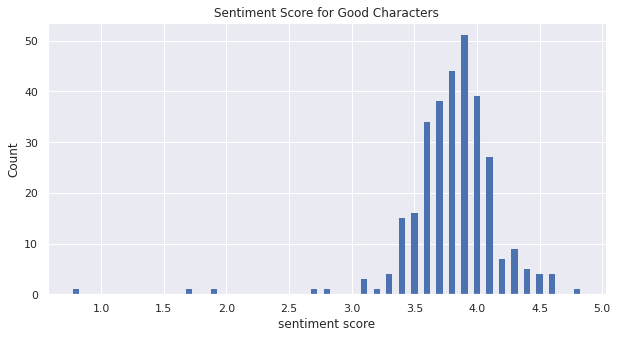

In [ ]:
# Plot Graph for Good Characters
with sns.axes_style("darkgrid"):
    plt.figure(figsize = [10, 5])
    plt.bar(sent, count, width=0.05, edgecolor = 'black',linewidth=0.01)
    plt.xlabel('sentiment score')
    plt.ylabel('Count')
    plt.title('Sentiment Score for Good Characters')
    plt.show()

**Good Character Stats**

In [ ]:
print("Mean: " + str(sum(sentiment_score_good.values()) / len(sentiment_score_good.values())))
print("1Oth Percentile: " + str(np.percentile(list(sentiment_score_good.values()),10)))
print("90th Percentile: " + str(np.percentile(list(sentiment_score_good.values()),90)))

Mean: 3.8100977198697064
1Oth Percentile: 3.5
90th Percentile: 4.1


### Bad Characters Analysis

In [ ]:
# Simmilarly, get only the bad characters
bad_df = df_good_and_bad[(df_good_and_bad['good'] == 0) & (df_good_and_bad['bad'] == 1)]

In [ ]:
# Sentiment Score list for only the good characters
sentiment_score_bad = filterTheDict(sentiment_score,bad_df)

sentiments = sorted([v for k,v in sentiment_score_bad.items()],reverse = True)
sentimentscount = collections.Counter(sentiments)
sent, count = zip(*sentimentscount.items())

# sentiment_score_bad

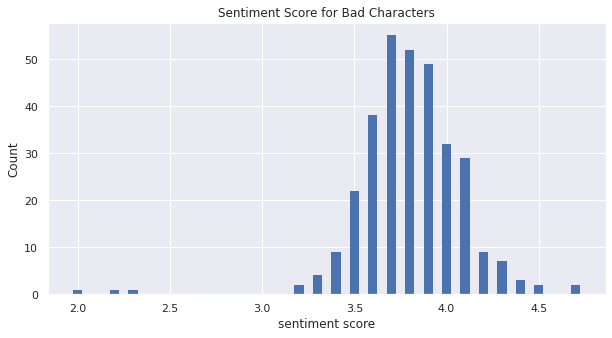

In [ ]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = [10, 5])
    plt.bar(sent, count, width=0.05, edgecolor = 'black',linewidth=0.01)
    plt.xlabel('sentiment score')
    plt.ylabel('Count')
    plt.title('Sentiment Score for Bad Characters')
    plt.show()

**Bad Character Stats** **bold text**

In [ ]:
print("Mean: " + str(sum(sentiment_score_bad.values()) / len(sentiment_score_bad.values())))
print("1Oth Percentile: " + str(np.percentile(list(sentiment_score_bad.values()),10)))
print("90th Percentile: " + str(np.percentile(list(sentiment_score_bad.values()),90)))

Mean: 3.802201257861638
1Oth Percentile: 3.5
90th Percentile: 4.1


### Hypothesis Checking

In [ ]:

original_char = list(pd.concat([good_df, bad_df])['hero']) #holds the original order of characters

good_chars = list(good_df["hero"])
bad_chars = list(bad_df["hero"])

mean_bad_chars = sum(sentiment_score_bad.values()) / len(sentiment_score_bad.values())
mean_good_chars = sum(sentiment_score_good.values()) / len(sentiment_score_good.values())

original_label = [] #hols the original orders of label (1 - good, 0 - bad)

for hero in df_good_and_bad['hero'].tolist():
  # if hero is in good_df it means that's good and then it should be assigned 1
  if hero in good_df["hero"].tolist():
    original_label.append(1)
  else:
    original_label.append(0)
  
# now we have original_char, and original_label which containais a List of The characters and a List of the original Labels (1 or 0)


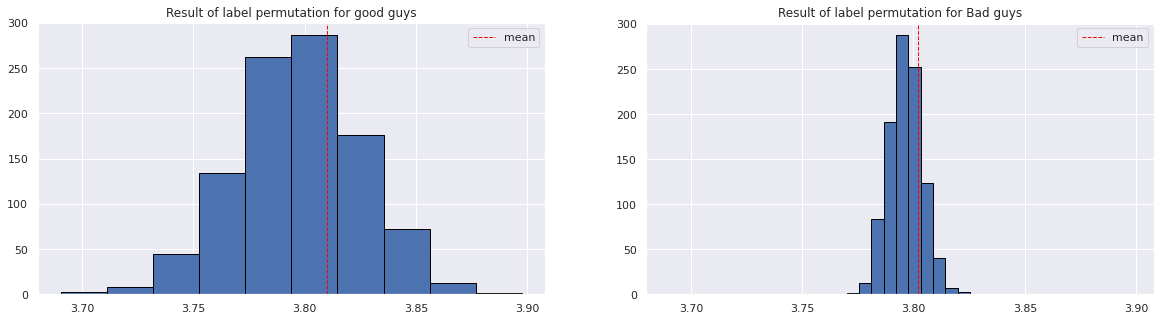

In [ ]:
# Sentiment for each Sample generated
sent_samples_good_chars = []
sent_samples_bad_chars = []

# Sample generation loop
for n in range(1000):
    '''
    For each Sample:
      1. shuffle bad and good labels
      2.  
    '''
    # Initialize sentiment bad and good
    sent_bad = 0
    sent_good = 0
    sent_good_count = 0 
    sent_bad_count = 0

    # Shuffle bad and good
    original_label = random.sample(original_label, k=len(original_label))


    # Loop Through the original_char list
    # figure it, if the char is good or bad (1 or 0)
    # get the sentiment score
    for c in original_char:
        good_or_bad = original_label[original_char.index(c)]
        if good_or_bad == 1:
            try:
              sent_good += sentiment_score[c]
              sent_good_count += 1
            except:
              continue
        if good_or_bad == 0:
            try:
              sent_bad += sentiment_score[c]
              sent_bad_count += 1
            except:
              continue
    
    # Divide the sum by the number of good/bad guys (in this sample)
    # Add this average to the average_sentiment_samples list
    sent_samples_good_chars.append(sent_good / sent_good_count)
    sent_samples_bad_chars.append(sent_bad / sent_bad_count)

# Plot a histogram of the averages
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20, 5))
axs[0].hist(sent_samples_good_chars, bins = 10, edgecolor='black')
axs[0].axvline(mean_good_chars, color='red', linestyle='dashed', linewidth=1, label="mean")
axs[0].set_title('Result of label permutation for good guys')
axs[0].legend()

axs[1].hist(sent_samples_bad_chars, bins = 10, edgecolor='black')
axs[1].axvline(mean_bad_chars, color='red', linestyle='dashed', linewidth=1, label="mean")
axs[1].set_title('Result of label permutation for Bad guys')
axs[1].legend()

plt.show()

## Conclusions

**Bad Vs. Good Characters**

All the stats were very similar in between the groups, which is counter intuitive. Besides that, both the 10th and 90th percetile are very similar for both groups, further indicating that the distributions are very similar. 